# Q Factor

## Reformat Data

**Import the two data tables.**
1. Table of all the relevant publications
2. List of all the SCOPUS_ID for authors of interest

In [1]:
from os import write

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data from Excel files
# Remove duplicate rows in each dataframe
df_all_works = pd.read_excel("Combined_Scopus_Published_Works.xlsx").drop_duplicates()
df_author_IDs = pd.read_excel("Scopus_IDs.xlsx").drop_duplicates()

# View overview of the large publication dataset
print("\n",df_all_works.describe())


              Authors               Author full names  Author(s) ID    Title  \
count          73088                           73089         73074    73074   
unique         63657                           64328         63063    67400   
top     Pollock B.E.  Pollock, Bruce E. (7103208372)    7103208372  Preface   
freq             101                              91           101       52   

         Year                                       Source title  Volume  \
count   73075                                              73069   70187   
unique    110                                               4539    1090   
top      2021  International Journal of Radiation Oncology Bi...       7   
freq     4474                                               8055    1565   

        Issue  Art. No.  Page start  ...     ISSN             ISBN    CODEN  \
count   64682      8734       63958  ...    67930             9441    50941   
unique    917      6480        7958  ...     4616             7

Create a new data table which takes all the authors' Scopus IDs, and lists all the publications and associated information for which they are listed.

In [2]:
# Convert SCOPUS_ID (i.e., author ID) from integer to string, needed for merge
df_author_IDs['SCOPUS_ID'] = df_author_IDs['SCOPUS_ID'].astype(str)

# Copy column that contains author IDs into a new column called 'All_Authors'
df_all_works['All_Authors'] = df_all_works['Author(s) ID']

# Split the 'Author(s) ID' column into separate rows in the all_works dataframe
# This will allow us to use merge to match the list of author IDs we have to their associated published works
df_all_works = df_all_works.assign(**{'Author(s) ID': df_all_works['Author(s) ID'].str.split('; ')}).explode('Author(s) ID')

# Merge the datasets on SCOPUS_ID and Author_ID to make a merged dataset with each publication listed for each author
merged_data = pd.merge(df_author_IDs, df_all_works, left_on='SCOPUS_ID', right_on='Author(s) ID', how='inner')

# Filter desired columns
desired_columns = ['SCOPUS_ID','Author_Name','Author full names','Title','Year','Source title','Cited by','DOI','Link','Authors with affiliations','Publisher','PubMed ID','Document Type','All_Authors'
                  ]
merged_data = merged_data[desired_columns]

# Convert SCOPUS ID back to integer
merged_data['SCOPUS_ID'] = merged_data['SCOPUS_ID'].astype('Int64')

#Filter desired columns for output and create Excel file
write_to_excel = True
if write_to_excel: 
    merged_data.to_excel('merged_dataframe.xlsx', index=False)

## Examine data characteristics

First, we will: 
- Determine total number of authors and publications
- Visualize publications per year

Number of distinct authors: 1263.
Number of distinct publications: 64747.


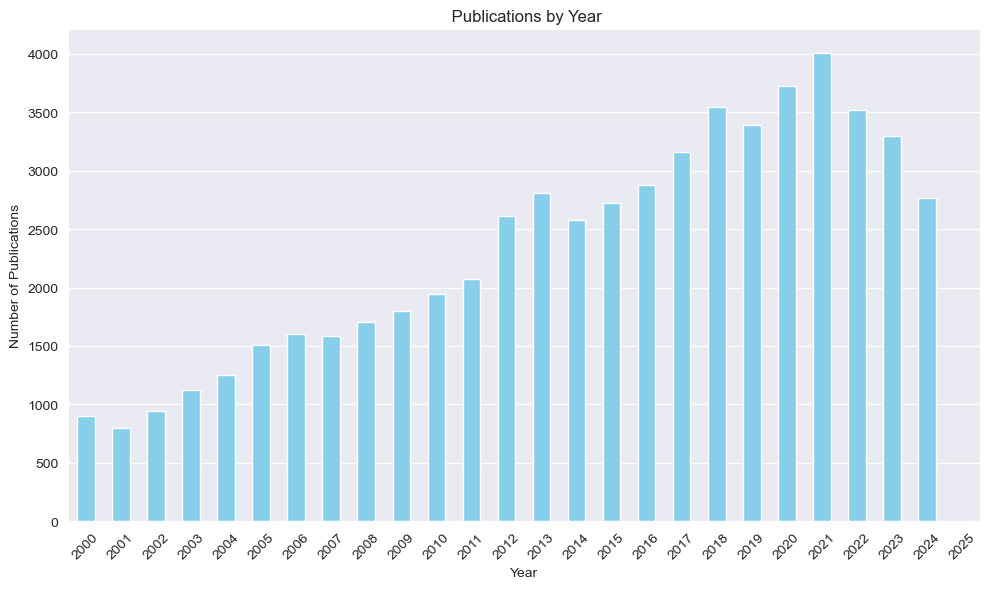

In [3]:
# Calculate number of unique authors and publications
print(f"Number of distinct authors: {merged_data['SCOPUS_ID'].nunique()}."
      f"\nNumber of distinct publications: {merged_data['Title'].nunique()}."
      )

# Filter and group data to count unique publications per year from {year} onwards
publications_per_year = (merged_data[merged_data['Year'] >= 2000]
    .groupby('Year')['Title']
    .nunique().reset_index(name='Number of Publications')
)

# Plotting publications per year
publications_per_year.plot(kind='bar', x='Year', y='Number of Publications', figsize=(10, 6), color='skyblue', legend=False)
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.title(' Publications by Year')
plt.xticks(rotation=45)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

- Confirm that the data in citations column are integers and without missing values.
- Calculate number of citations per author
- Calculate number of publications per author

In [4]:
### Confirm the citations column has values that are all integers
all_integers = merged_data['Cited by'].apply(lambda x: isinstance(x, int))
print(f"All values in citation column are integers: {all_integers.all()}")

# Count the number of missing (NaN) and empty values
missing_values = merged_data['Cited by'].isna().sum() + (merged_data['Cited by'] == '').sum()
print(f"Number of missing or empty values in citation column: {missing_values}")

### Calculate the average number of citations per author
citations_per_author = merged_data.groupby('SCOPUS_ID')['Cited by'].mean().mean()
print(f"Average number of citations per author: {citations_per_author:.8f}\n")

### Count the number of publications per SCOPUS_ID (author)
publications_per_author = merged_data['SCOPUS_ID'].value_counts().reset_index()
publications_per_author.columns = ['SCOPUS_ID', 'Number_of_Publications']

### Summary Statistics related to publications_per_author
pubs_info = publications_per_author['Number_of_Publications']

summary_stats = {
    'Total Number of Authors': len(publications_per_author),
    'Average publications per author': pubs_info.mean(),
    'Max': pubs_info.max(),
    'Min': pubs_info.min(),
    'SD': pubs_info.std(),
    'Median': pubs_info.median(),
}

# Print the summary statistics
for key, value in summary_stats.items():
    print(f"{key}: {value}")

# Saving statistics to Excel if desired
write_to_excel = False
if write_to_excel:
    with pd.ExcelWriter('publications_per_author.xlsx') as writer:
        publications_per_author.to_excel(writer, sheet_name='Publication Counts', index=False)
        summary_stats_df = pd.DataFrame(list(summary_stats.items()), columns=['Statistic', 'Value'])
        summary_stats_df.to_excel(writer, sheet_name='Summary Statistics', index=False)


All values in citation column are integers: True
Number of missing or empty values in citation column: 0
Average number of citations per author: 37.82047526

Total Number of Authors: 1263
Average publications per author: 99.55898653998416
Max: 1139
Min: 1
SD: 113.26881114434329
Median: 62.0


## Calculate Q factor

$$
Q_{i} = e^{\frac{1}{N}\sum_{a=1}^{N}\log_{}(c_{5,ia})}-\mu_{p} 
$$

We will calculate Q-factor with the following conditions:
- Publications from 2020 onwards will be excluded to allow for at least 5-year citation data
- For now, we will ignore the constant, $\mu_{p}$, due to the authors of interest being in the same field - radiation oncology
- Currently, a publication with 1 citation is weighted as equally as a publication with 0 citations

In [5]:
# Step 1: Filter the merged_data to include only years 2019 and before
filtered_data = merged_data[merged_data['Year'] <= 2019].copy()
# Convert to numeric and drop NaNs
filtered_data['Cited by']= pd.to_numeric(filtered_data['Cited by'], errors='coerce').dropna()
# Convert zeroes with ones to handle log(0)
filtered_data['Cited by']= filtered_data['Cited by'].replace(0, 1)
print(f"Total authors is {filtered_data['SCOPUS_ID'].nunique()}")

# Step 2: Define function to calculate q_factor for each author
def calculate_q_factor(group):
    total_publications = len(group)
    sum_log_citations = np.sum(np.log10(group['Cited by']))
    if total_publications == 0:
        return pd.Series([0, 0], index=['Q_factor','total_publications']) 
    else:
        q_factor = np.exp(sum_log_citations / total_publications)
    return pd.Series([q_factor,total_publications], index=['Q_factor','total_publications'])

# Step 3: Group by SCOPUS_ID and apply the calculate_q_factor function
q_factors = filtered_data.groupby('SCOPUS_ID').apply(calculate_q_factor,include_groups=False).reset_index()

# Step 4: Add author names to q factor dataframe 
q_factors = q_factors.merge(filtered_data.groupby('SCOPUS_ID')['Author_Name'].first().reset_index(), on='SCOPUS_ID')

# Reorder columns
q_factors = q_factors[['SCOPUS_ID', 'Author_Name', 'Q_factor', 'total_publications']]

# Write q_factors to a file
write_to_excel = True
if write_to_excel:
    with pd.ExcelWriter('Q_factors.xlsx') as writer:
        q_factors.to_excel(writer, sheet_name='Q_factors', index=False)
        filtered_data.to_excel(writer, sheet_name='2019_data', index=False)

Total authors is 1251


### Check Q-factor distribution

Now, we have generated the q_factors. We will next check their distribution with:
- Histogram
- Shapiro-Wilk test
- Q-q plot

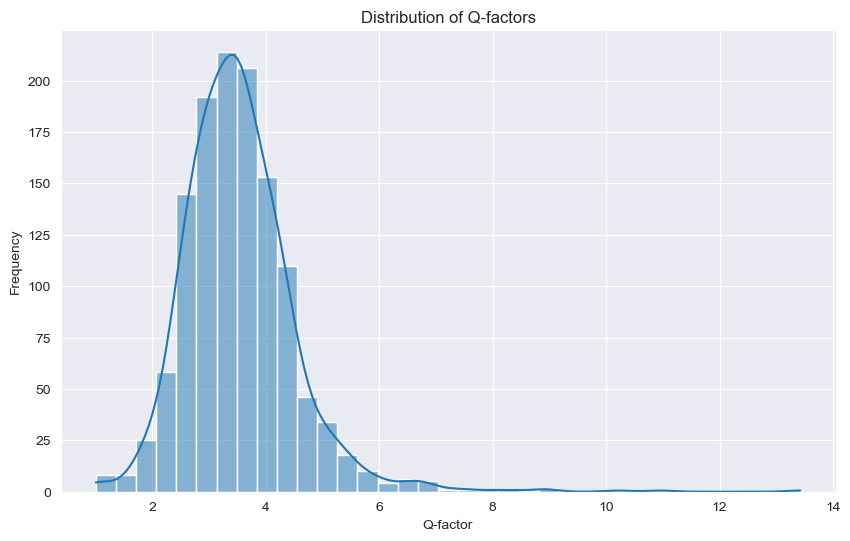

Shapiro-Wilk Test: Statistics=0.884, p=0.000
Sample does not look Gaussian (reject H0)


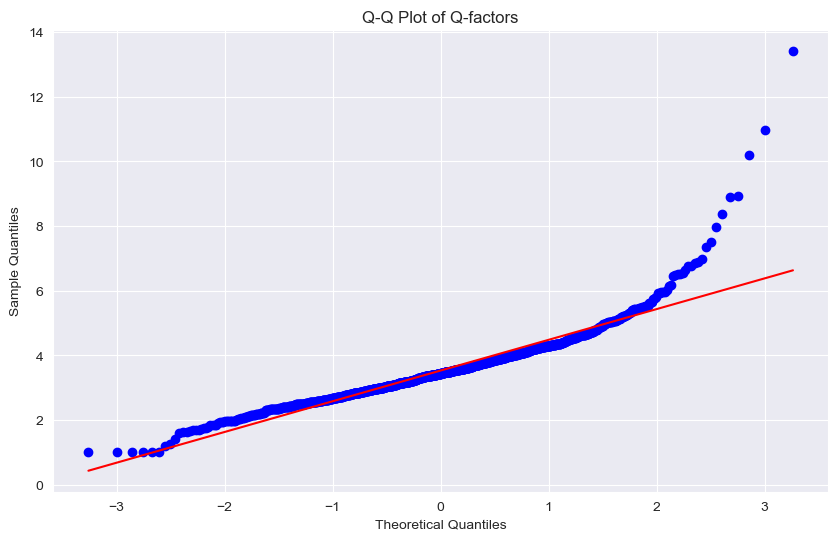

In [6]:
import seaborn as sns
from scipy.stats import shapiro, probplot

# Plot histogram of q_factors
plt.figure(figsize=(10, 6))
sns.histplot(q_factors['Q_factor'], kde=True, bins=int(np.sqrt(len(q_factors['Q_factor']))))
plt.title('Distribution of Q-factors')
plt.xlabel('Q-factor')
plt.ylabel('Frequency')
plt.show()

# Shapiro-Wilk Test
stat, p = shapiro(q_factors['Q_factor'])
print('Shapiro-Wilk Test: Statistics=%.3f, p=%.3f' % (stat, p))
# Interpret the result
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

# Q-Q plot
plt.figure(figsize=(10, 6))
probplot(q_factors['Q_factor'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Q-factors')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

Summary statistics for the Q factor

Descriptive statistics for Q_factor:
                   Statistic      Value
0                       Mean   3.533571
1                        Std   1.009951
2                     Median   3.438546
3                        Min   1.000000
4                        Max  13.422040
5       Q1 (25th percentile)   2.912636
6       Q3 (75th percentile)   4.003822
7  IQR (Interquartile Range)   1.091186


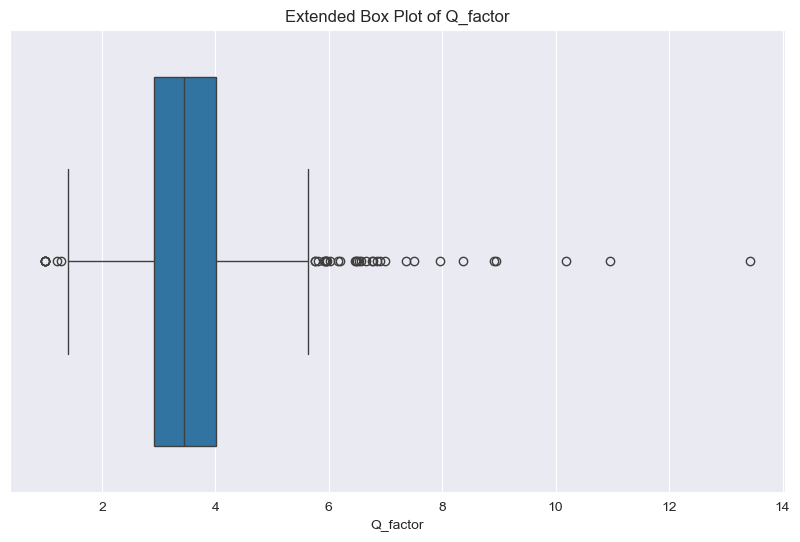

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to generate descriptive statistics and extended box plot
def generate_statistics_and_boxplot(data, column_name):
    # Extract values from the column
    values = data[column_name]
    
    # Calculate descriptive statistics
    column_mean = values.mean()
    column_std = values.std()
    column_median = values.median()
    column_min = values.min()
    column_max = values.max()
    column_q1 = values.quantile(0.25)
    column_q3 = values.quantile(0.75)
    column_iqr = column_q3 - column_q1

    # Create a descriptive statistics summary DataFrame
    column_summary = pd.DataFrame({
        'Statistic': ['Mean', 'Std', 'Median', 'Min', 'Max', 'Q1 (25th percentile)', 'Q3 (75th percentile)', 'IQR (Interquartile Range)'],
        'Value': [column_mean, column_std, column_median, column_min, column_max, column_q1, column_q3, column_iqr]
    })

    print(f"Descriptive statistics for {column_name}:")
    print(column_summary)

    # Create an extended box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=values, whis=1.5)
    plt.title(f'Extended Box Plot of {column_name}')
    plt.xlabel(column_name)
    plt.show()

generate_statistics_and_boxplot(q_factors, 'Q_factor')

3 random scientists with different Q-factors were selected. Each of their publications was graphed as a function of years since their first publication and total number of citations for that publication. 

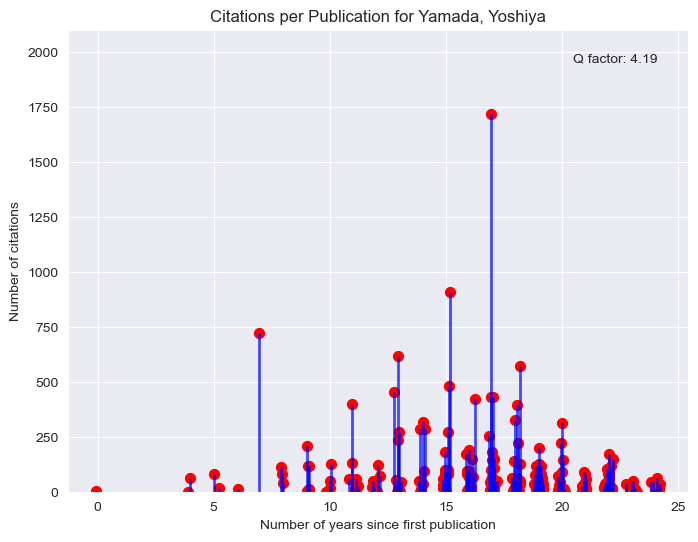

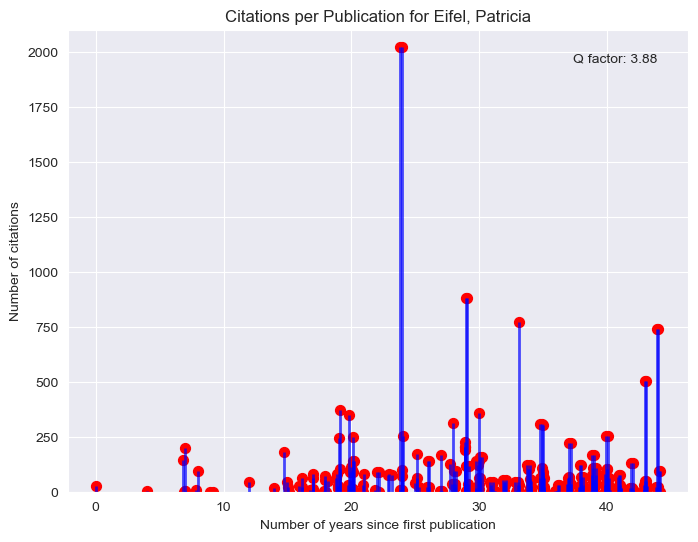

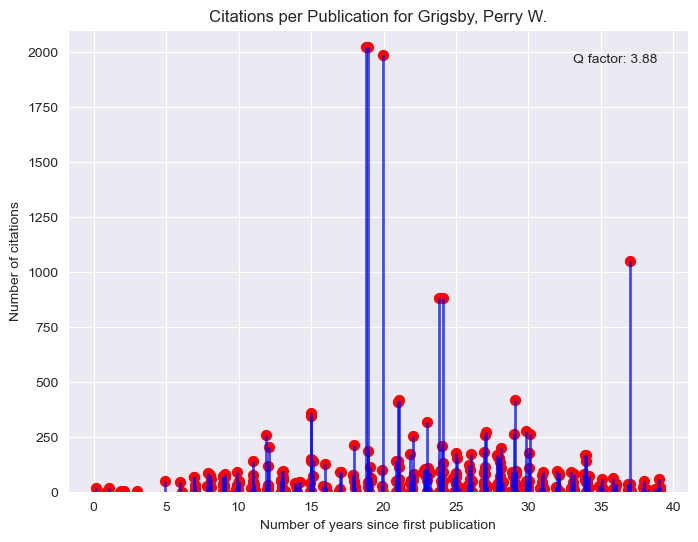

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Filter scientists with at least 100 publications
scientists_with_100_publications = q_factors[q_factors['total_publications'] >= 100]

# Select three random scientists with different Q-factors among those with at least 100 publications
random_scientists = scientists_with_100_publications.sample(n=3, random_state=2)

# Function to add random jitter to the x-values
np.random.seed(0)  # For reproducibility
def add_jitter(values, jitter_amount=0.1):
    return values + np.random.normal(0, jitter_amount, size=values.shape)

# Generate vertical lollipop plots
for idx, (scopus_id, author_name, q_factor, _) in random_scientists.iterrows():
    author_data = filtered_data[filtered_data['SCOPUS_ID'] == scopus_id].copy()
    author_data['Years Since First Publication'] = author_data['Year'] - author_data['Year'].min()

    # Add jitter to 'Years Since First Publication'
    jittered_x = add_jitter(author_data['Years Since First Publication'].values)

    plt.figure(figsize=(8, 6))
    # Plot the stick
    plt.vlines(x=jittered_x, ymin=0, ymax=author_data['Cited by'], color='blue',
               alpha=0.7, linewidth=2)
    # Plot the dot
    plt.scatter(x=jittered_x, y=author_data['Cited by'], color='red', alpha=1,
                s=50)
    plt.ylim(0, 2100)  # Set max y-value to 2000
    plt.xlabel("Number of years since first publication")
    plt.ylabel('Number of citations')
    plt.title(f'Citations per Publication for {author_name}')
    plt.text(0.95, 0.95, f'Q factor: {q_factor:.2f}', ha='right', va='top', transform=plt.gca().transAxes)
    plt.show()

**It is noticed that the authors with the highest q-factor have the fewest number of publications as seen below**

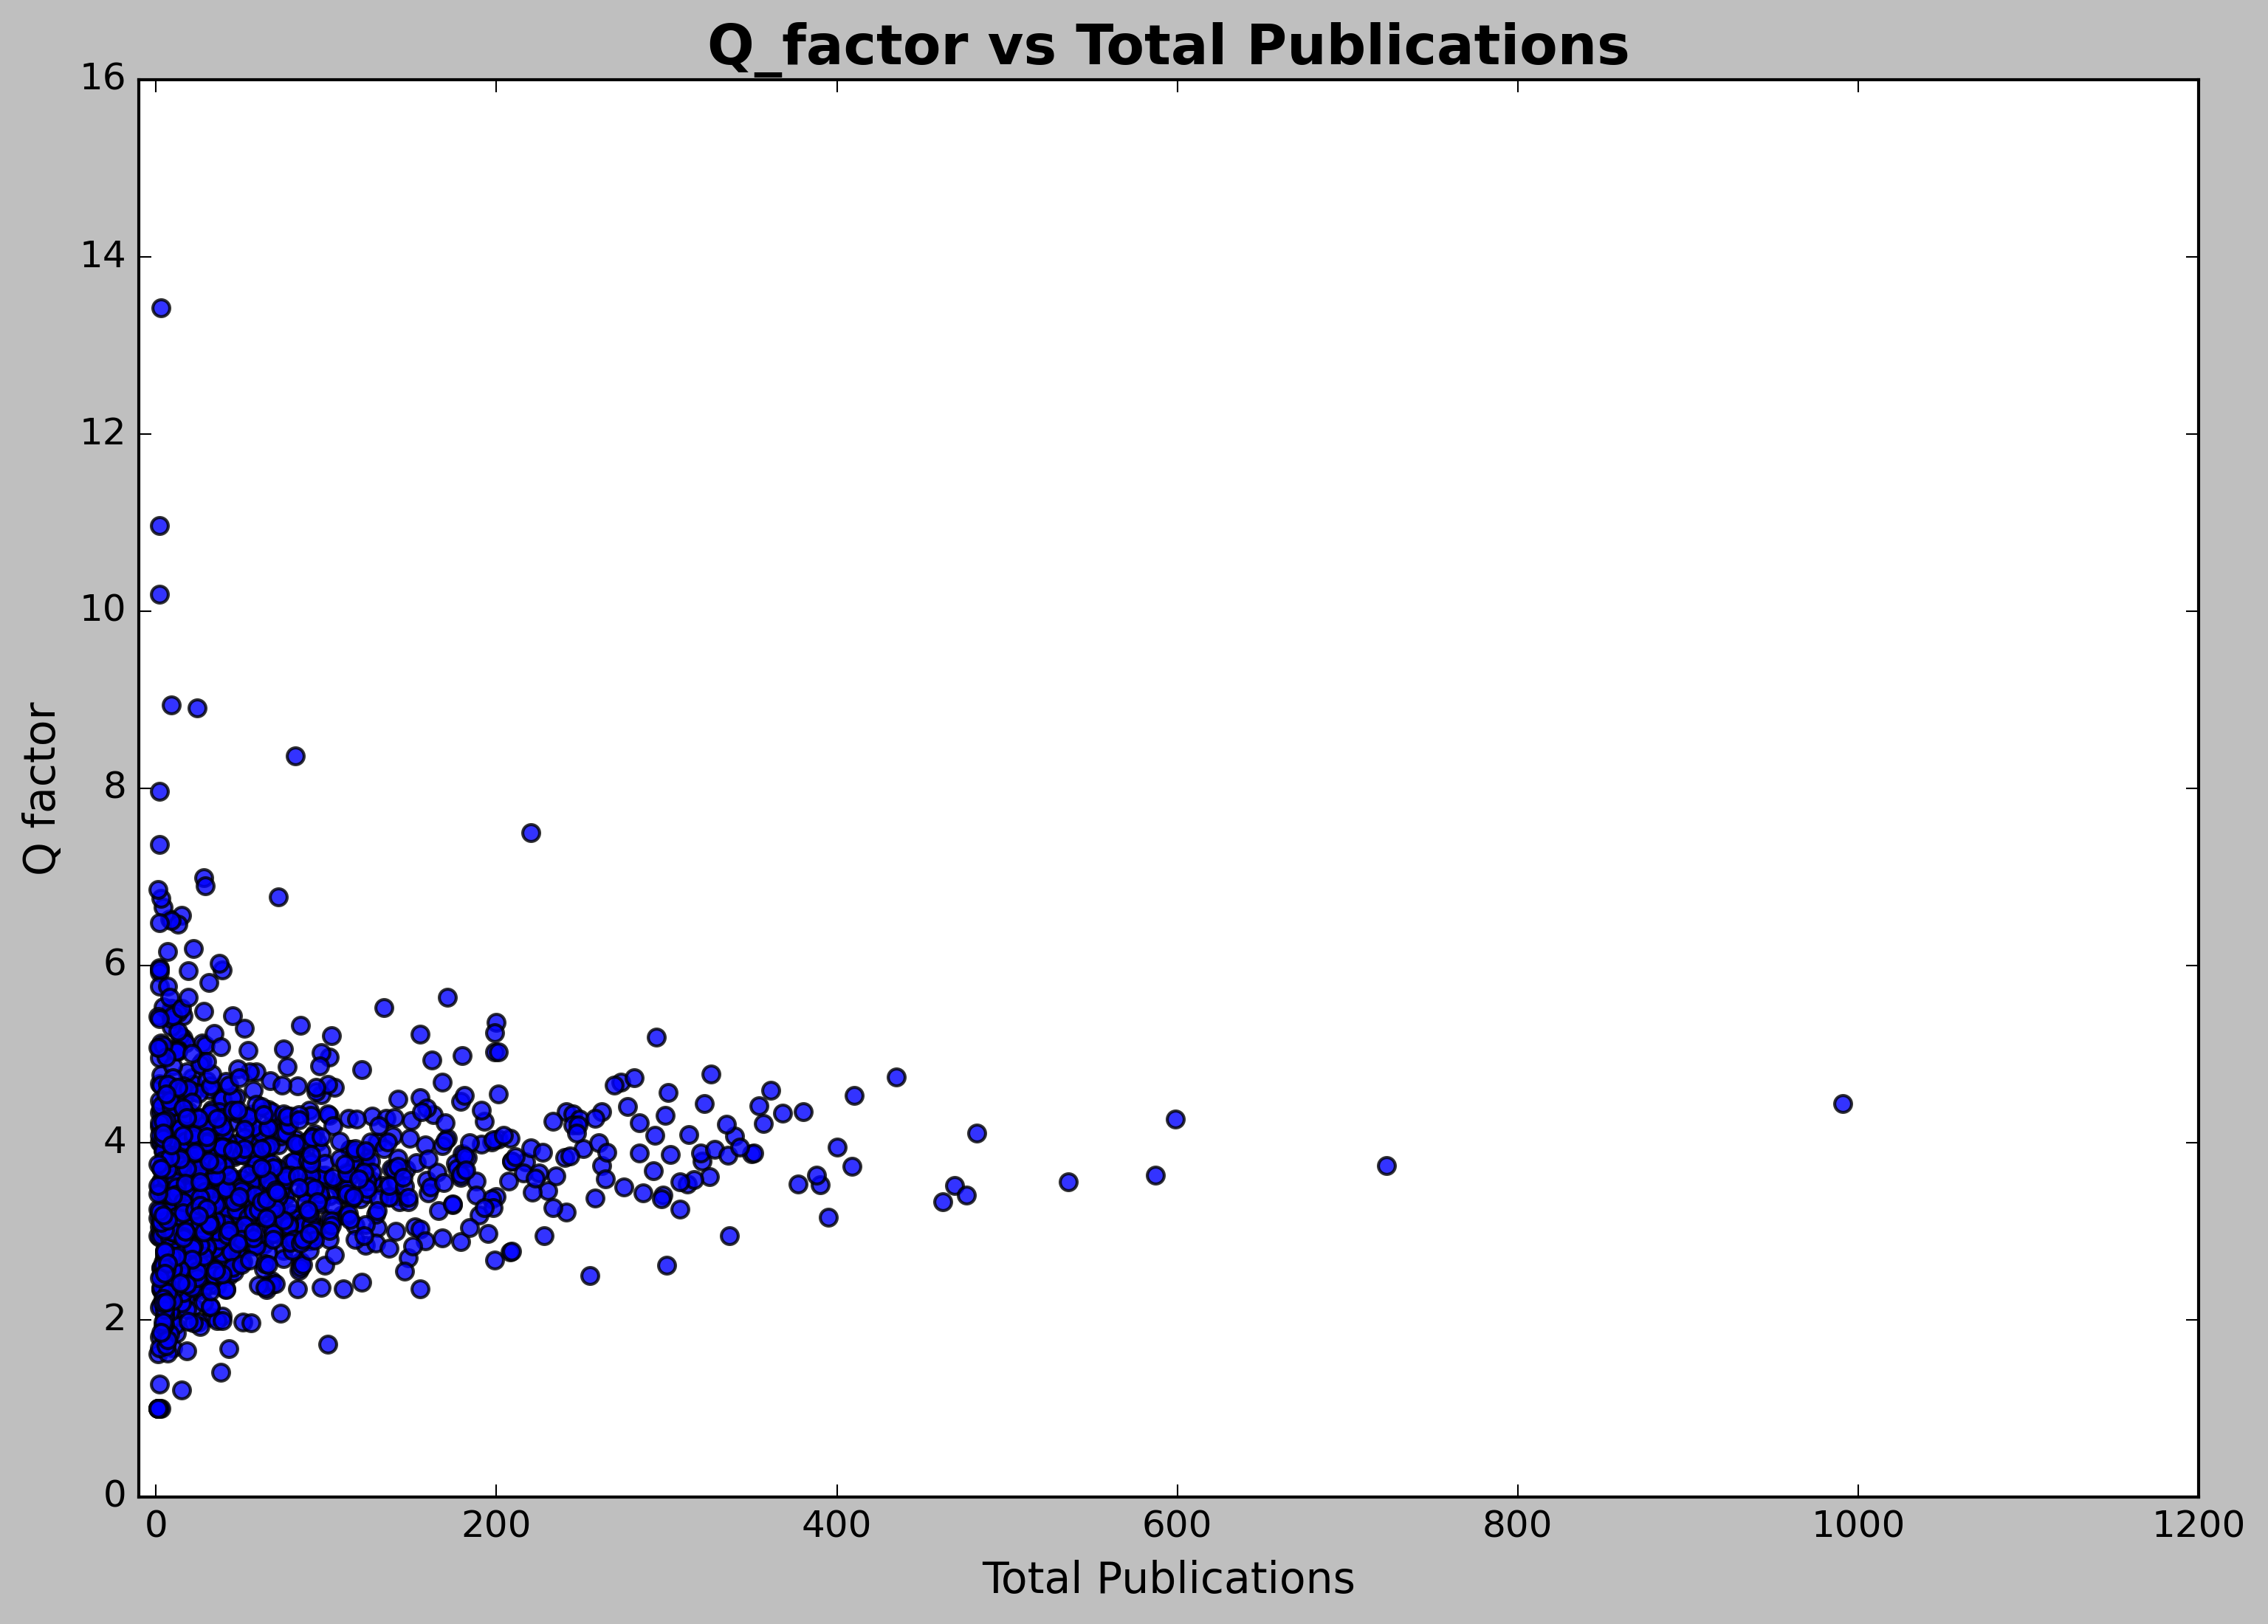

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the scatter plot
plt.style.use('classic')
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
scatter = ax.scatter(q_factors['total_publications'], q_factors['Q_factor'], alpha=0.8, edgecolors='black', s=30, c='blue')

# Adding titles and labels
ax.set_title('Q_factor vs Total Publications', fontsize=18, weight='bold')
ax.set_xlabel('Total Publications', fontsize=14)
ax.set_ylabel('Q factor', fontsize=14)

# Set x-axis to start at 0
# Adjust tick parameters
ax.set_xlim(left=-10)
ax.tick_params(axis='both', which='major', labelsize=12)

# Adding a grid
#ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Saving the plot to a file
plt.savefig('Q_factor_vs_publications.png', bbox_inches='tight')

plt.show()